**Install requirements**

In [8]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

**Set arguments**


In [2]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.001          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 5

**Define Data Preprocessing**

In [3]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [4]:
# Clone github repository with data
if not os.path.isdir('./pacs'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS
  !mv 'Homework3-PACS' 'pacs'

DATA_DIR = 'pacs/PACS'

# Prepare Pytorch train/test Datasets
p_set=torchvision.datasets.ImageFolder(DATA_DIR+'/photo', transform = train_transform)
a_set=torchvision.datasets.ImageFolder(DATA_DIR+'/art_painting', transform = eval_transform)
c_set=torchvision.datasets.ImageFolder(DATA_DIR+'/cartoon')
s_set=torchvision.datasets.ImageFolder(DATA_DIR+'/sketch')

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 34.04 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.


**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(p_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

test_dataloader = DataLoader(a_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [6]:
if not os.path.isdir('./aiml2020'):
  !git clone https://github.com/GianlucaMega/aiml2020.git

from aiml2020.alexnet_modified import AlexNet

net = alexnet(pretrained=True) # Loading AlexNet model

net.add_module('dom_classifier', nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
        ))

net.dom_classifier.load_state_dict(net.classifier.state_dict())
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 7 outputs for PACS
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
net.dom_classifier[6] = nn.Linear(4096, 2)


# We just changed the last layer of AlexNet with a new fully connected layer with 7 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

Cloning into 'aiml2020'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 40 (delta 9), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (40/40), done.


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


**Prepare Training**

In [7]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [8]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0

losses = [0 for i in range(NUM_EPOCHS)]

accuracy = [0 for i in range(NUM_EPOCHS)]

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  tot_epoch_losses = 0
  tot_epoch_steps = 0
  running_corrects = 0

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    tot_epoch_losses += loss.item()
    tot_epoch_steps += 1

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Calculate Accuracy
  accuracy[epoch] = running_corrects / float(tot_epoch_steps)
  losses[epoch] = tot_epoch_losses/tot_epoch_steps

  # Step the scheduler
  scheduler.step() 



Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 2.0055103302001953
Starting epoch 2/30, LR = [0.001]
Step 10, Loss 0.4269504249095917
Starting epoch 3/30, LR = [0.001]
Starting epoch 4/30, LR = [0.001]
Step 20, Loss 0.1722967028617859
Starting epoch 5/30, LR = [0.001]
Starting epoch 6/30, LR = [0.001]
Step 30, Loss 0.16630223393440247
Starting epoch 7/30, LR = [0.001]
Step 40, Loss 0.1005811095237732
Starting epoch 8/30, LR = [0.001]
Starting epoch 9/30, LR = [0.001]
Step 50, Loss 0.1123693510890007
Starting epoch 10/30, LR = [0.001]
Starting epoch 11/30, LR = [0.001]
Step 60, Loss 0.08417949080467224
Starting epoch 12/30, LR = [0.001]
Step 70, Loss 0.04433145374059677
Starting epoch 13/30, LR = [0.001]
Starting epoch 14/30, LR = [0.001]
Step 80, Loss 0.060213327407836914
Starting epoch 15/30, LR = [0.001]
Starting epoch 16/30, LR = [0.001]
Step 90, Loss 0.05724790319800377
Starting epoch 17/30, LR = [0.001]
Step 100, Loss 0.0437125563621521
Starting epoch 18/30, LR = [0.001]
Starting epoch 19/30, LR = [0.001]
Step 110,

		LOSS


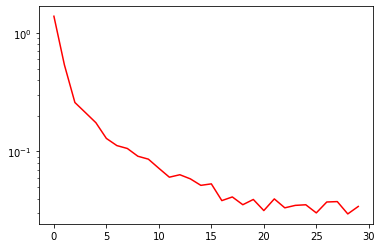

		ACCURACY


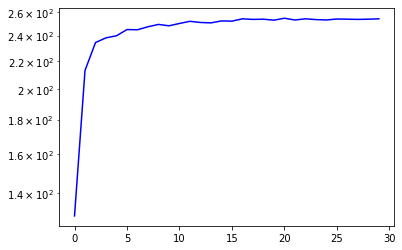

In [9]:
print("\t\tLOSS")
plt.figure()
plt.plot(range(NUM_EPOCHS), losses, color='red')
plt.semilogy()
plt.show()
print("\t\tACCURACY")
plt.figure()
plt.plot(range(NUM_EPOCHS), accuracy, color='blue')
plt.semilogy()
plt.show()

**Test**

In [11]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(a_set))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Test Accuracy: 0.45556640625
